# Demo: August 2026 extremes forecast (Madrid)

**Goal:** predict August 2026:
- `max_tmax` (monthly maximum of daily tmax)
- `min_tmin` (monthly minimum of daily tmin)

**Approach (2-step):**
1) fit a simple trend model for August means: `year -> mean_tmax`, `year -> mean_tmin`
2) reconstruct extremes via historical deviations (deltas):

- `delta_max = max_tmax - mean_tmax`  → `max_2026 = mean_tmax_2026 + Q_q(delta_max)`
- `delta_min = mean_tmin - min_tmin`  → `min_2026 = mean_tmin_2026 - Q_q(delta_min)`

Quantile `q` is chosen by rolling backtest to minimize MAE on recent years.


In [1]:
from __future__ import annotations

from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

from src.config import SETTINGS
from src.fetch_openmeteo import fetch_daily
from src.features import load_daily_csv, august_yearly_table
from src.model import forecast_august_2026_extremes

ROOT = Path("..").resolve()
DATA_PATH = ROOT / "data" / "raw" / "madrid_daily.csv"

pd.set_option("display.width", 200)
pd.set_option("display.max_columns", 50)

DATA_PATH


WindowsPath('C:/Users/tomaf/PycharmProjects/min-max-august-forecast/data/raw/madrid_daily.csv')

### Quick data sanity checks

Loaded daily weather data for Madrid from **1980-01-01** to **2025-12-30** (`16801` rows).
Basic integrity checks look good:
- `unique_dates == rows` → no duplicate dates
- `tmax < tmin == 0` → physical consistency holds after cleaning

So the dataset is continuous and consistent enough to safely aggregate into yearly August features.


In [2]:
DATA_PATH.parent.mkdir(parents=True, exist_ok=True)

if not DATA_PATH.exists():
    df = fetch_daily(
        latitude=SETTINGS.latitude,
        longitude=SETTINGS.longitude,
        timezone=SETTINGS.timezone,
        start_date=SETTINGS.start_date,
    )
    df.to_csv(DATA_PATH, index=False)

daily = load_daily_csv(str(DATA_PATH))

checks = pd.DataFrame([{
    "date_min": daily["date"].min(),
    "date_max": daily["date"].max(),
    "rows": len(daily),
    "unique_dates": daily["date"].nunique(),
    "duplicates": len(daily) - daily["date"].nunique(),
    "tmax<tmin": int((daily["tmax"] < daily["tmin"]).sum()),
}])
checks


,date_min,date_max,rows,unique_dates,duplicates,tmax<tmin
0,1980-01-01,2025-12-30,16801,16801,0,0


### Yearly August features

Daily data is aggregated to **one row per year (August only)**:

- `mean_tmax` / `mean_tmin` — average daily maximum / minimum temperature in August
- `max_tmax` / `min_tmin` — monthly extremes (hottest day / coldest night in August)
- `delta_max = max_tmax - mean_tmax`
- `delta_min = mean_tmin - min_tmin`

This representation separates:
- a **stable signal** (August means, suitable for trend modeling),
- from **extreme deviations** (deltas), which capture rare events and are handled statistically.

The table above shows the last 5 available Augusts used as context for the 2026 forecast.


In [3]:
yearly = august_yearly_table(daily, min_days_in_aug=SETTINGS.min_days_in_aug)
yearly.tail(5)


,year,mean_tmax,max_tmax,mean_tmin,min_tmin,delta_max,delta_min
41,2021,33.612903,41.5,19.312903,13.8,7.887097,5.512903
42,2022,34.154839,38.3,20.480645,14.6,4.145161,5.880645
43,2023,34.996774,40.0,20.464516,13.5,5.003226,6.964516
44,2024,35.183871,39.8,21.051613,15.9,4.616129,5.151613
45,2025,35.080645,40.7,22.083871,16.7,5.619355,5.383871


### August mean temperatures (trend signal)

Both `mean_tmax` and `mean_tmin` show a clear long-term upward trend and are much smoother than monthly extremes.
This makes them suitable targets for trend modeling based on the `year` feature.
This is why the model is fitted on August means first, while extremes are reconstructed separately.

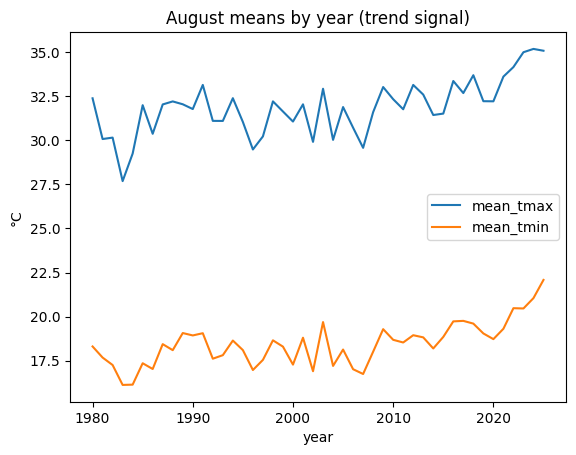

In [4]:
plt.figure()
plt.plot(yearly["year"], yearly["mean_tmax"], label="mean_tmax")
plt.plot(yearly["year"], yearly["mean_tmin"], label="mean_tmin")
plt.title("August means by year (trend signal)")
plt.xlabel("year")
plt.ylabel("°C")
plt.legend()
plt.show()


### Delta distributions (extreme deviations)

The histograms show how far August extremes typically deviate from the monthly mean.
`delta_max` is relatively concentrated, while `delta_min` is more dispersed, reflecting the higher variability of cold-night extremes.

These distributions motivate using a **quantile-based** estimate for reconstructing monthly extremes instead of direct prediction.


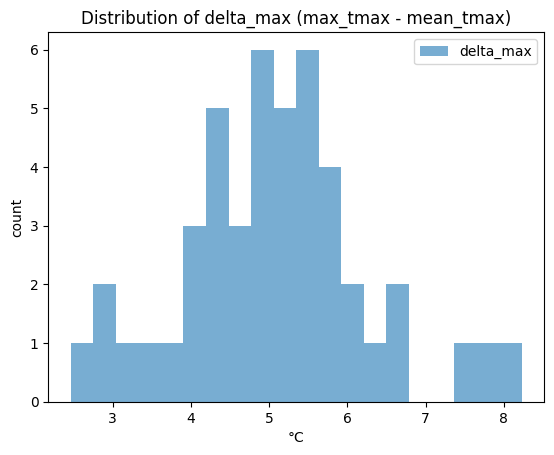

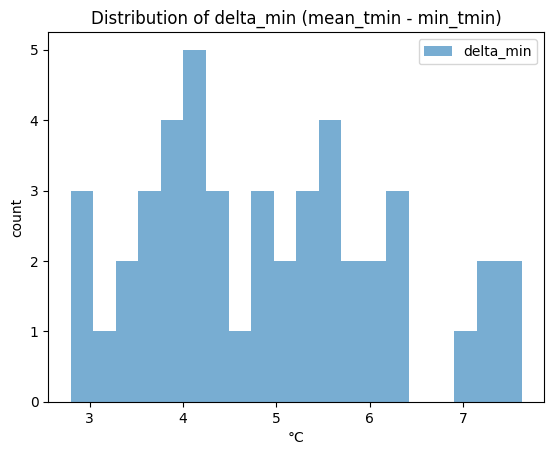

In [5]:
plt.figure()
plt.hist(yearly["delta_max"].dropna(), bins=20, alpha=0.6, label="delta_max")
plt.title("Distribution of delta_max (max_tmax - mean_tmax)")
plt.xlabel("°C")
plt.ylabel("count")
plt.legend()
plt.show()

plt.figure()
plt.hist(yearly["delta_min"].dropna(), bins=20, alpha=0.6, label="delta_min")
plt.title("Distribution of delta_min (mean_tmin - min_tmin)")
plt.xlabel("°C")
plt.ylabel("count")
plt.legend()
plt.show()


In [6]:
pred = forecast_august_2026_extremes(
    yearly=yearly,
    year=2026,
    window_years=20,
    alpha=SETTINGS.alpha,
    degree=SETTINGS.degree,
    min_train_years=SETTINGS.min_train_years,
    eval_last_years=SETTINGS.q_eval_last_years,
)

summary = pd.DataFrame([{
    "q_max": pred.q_max,
    "q_min": pred.q_min,
    "delta_max": pred.delta_max,
    "delta_min": pred.delta_min,
    "mae_max": pred.mae_max,
    "mae_min": pred.mae_min,
    "max_tmax_2026": pred.max_tmax,
    "min_tmin_2026": pred.min_tmin,
}])
summary


,q_max,q_min,delta_max,delta_min,mae_max,mae_min,max_tmax_2026,min_tmin_2026
0,0.7,0.7,5.685161,5.718065,1.31546,1.365083,40.814081,15.514638


MAE (in °C) summarizes the typical absolute error observed during rolling backtesting.
Lower MAE for `q = 0.7` indicates a better balance between capturing representative August extremes
and avoiding sensitivity to rare outliers.

Overall, the model provides a reasonable point estimate of typical August extremes given its simplicity.
